## **PROJECT EWS KELULUSAN MAHASISWA**

In [4]:
# --- GRUP 1: LIBRARY INTI
import pandas as pd
import numpy as np

# --- GRUP 2: LIBRARY VISUALISASI
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# --- GRUP 3: LIBRARY MACHINE LEARNING
# A. Preprocessing (Nyiapin Data)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# B. Model Klasifikasi
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb # Penting untuk model terbaik

# C. Evaluasi & Interpretasi Model
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, confusion_matrix
import shap

import warnings
warnings.filterwarnings('ignore')

print("Semua 'alat perang' Klasifikasi siap tempur! 🔥")

C:\Users\Inzaghi\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Semua 'alat perang' Klasifikasi siap tempur! 🔥


In [5]:
# ====================================================================
# LANGKAH A: LOAD DATA
# ====================================================================

print("\nMulai me-load 7 file CSV...")

# 'pd.read_csv' itu perintah buat "baca file CSV"
info = pd.read_csv('Data/studentInfo.csv')
courses = pd.read_csv('Data/courses.csv')
assessments = pd.read_csv('Data/assessments.csv')
student_assessment = pd.read_csv('Data/studentAssessment.csv')
vle = pd.read_csv('Data/vle.csv')
student_vle = pd.read_csv('Data/studentVle.csv')
student_registration = pd.read_csv('Data/studentRegistration.csv')

print("✅ Selesai! Semua 7 file CSV berhasil di-load.")


Mulai me-load 7 file CSV...
✅ Selesai! Semua 7 file CSV berhasil di-load.


In [6]:
# ====================================================================
# LANGKAH B: TENTUKAN TARGET PREDIKSI
# ====================================================================

# Buat kolom baru 'target_lulus'
# 1 (Lulus) = Pass atau Distinction (15385 data)
# 0 (Gagal/Mundur) = Fail atau Withdrawn (17208 data)
info['target_lulus'] = info['final_result'].apply(
    lambda x: 1 if x in ['Pass', 'Distinction'] else 0
)

print(f"\nBerhasil membuat kolom 'target_lulus'. (0: {info['target_lulus'].value_counts()[0]}, 1: {info['target_lulus'].value_counts()[1]})")


Berhasil membuat kolom 'target_lulus'. (0: 17208, 1: 15385)


In [7]:
# ====================================================================
# LANGKAH C: FEATURE ENGINEERING (Fokus EWS 30 Hari)
# ====================================================================

HARI_PREDIKSI = 30
print(f"\nMenetapkan titik prediksi EWS pada: Hari ke-{HARI_PREDIKSI}")

# 1. Filter data aktivitas VLE dan Assessment (HANYA 30 HARI PERTAMA)
student_vle_early = student_vle[student_vle['date'] <= HARI_PREDIKSI]
student_assessment_early = student_assessment[student_assessment['date_submitted'] <= HARI_PREDIKSI]
print("✅ Data aktivitas VLE dan Assessment telah difilter.")

# --- C.1: Fitur Perilaku Dasar (EWS 30 Hari) ---
# 1. Total Klik (sum_click)
total_clicks_early = student_vle_early.groupby('id_student')['sum_click'].sum().reset_index(name='total_clicks_early')

# 2. Total Hari Aktif (nunique date)
active_days_early = student_vle_early.groupby('id_student')['date'].nunique().reset_index(name='total_hari_aktif_early')

# 3. Rata-rata Nilai (mean score)
avg_score_early = student_assessment_early.groupby('id_student')['score'].mean().reset_index(name='avg_score_early')
print("✅ Fitur 'total_clicks_early', 'total_hari_aktif_early', dan 'avg_score_early' dibuat.")


# --- C.2: Fitur Perilaku Expert (Durasi Partisipasi - EWS 30 Hari) ---
# Durasi: Hari klik terakhir - Hari klik pertama
df_durasi_early = student_vle_early.groupby('id_student')['date'].agg(['min', 'max'])
df_durasi_early['durasi_partisipasi_early'] = (df_durasi_early['max'] - df_durasi_early['min'])
df_durasi_early['durasi_partisipasi_early'] = df_durasi_early['durasi_partisipasi_early'].fillna(0)
fitur_durasi_early = df_durasi_early[['durasi_partisipasi_early']].reset_index()
print("✅ Fitur 'durasi_partisipasi_early' (Expert) dibuat.")


# --- C.3: Fitur Demografis (One-Hot Encoding) ---
kategori_cols = ['gender', 'region', 'highest_education', 'disability']
df_kategori = pd.get_dummies(info[kategori_cols], drop_first=True)
print(f"✅ Berhasil membuat {df_kategori.shape[1]} kolom fitur demografis baru.")


Menetapkan titik prediksi EWS pada: Hari ke-30
✅ Data aktivitas VLE dan Assessment telah difilter.
✅ Fitur 'total_clicks_early', 'total_hari_aktif_early', dan 'avg_score_early' dibuat.
✅ Fitur 'durasi_partisipasi_early' (Expert) dibuat.
✅ Berhasil membuat 18 kolom fitur demografis baru.


In [10]:
# ====================================================================
# LANGKAH D: BUAT TABEL MASTER (Gabung & Bersihkan)
# ====================================================================

# 1. Gabung semua tabel fitur ke 'info'
df_master = pd.merge(info, total_clicks_early, on='id_student', how='left')
df_master = pd.merge(df_master, active_days_early, on='id_student', how='left')
df_master = pd.merge(df_master, avg_score_early, on='id_student', how='left')
df_master = pd.merge(df_master, fitur_durasi_early, on='id_student', how='left')

# Gabung dengan fitur demografis (Pastikan indeks sejajar)
df_master = df_master.reset_index(drop=True)
df_kategori = df_kategori.reset_index(drop=True)
df_expert = pd.concat([df_master, df_kategori], axis=1)

# 2. Bersihkan NaN (mengisi dengan 0 karena NaN di fitur EWS berarti tidak ada aktivitas/nilai)
kolom_numerik_untuk_dibersihkan = ['total_clicks_early', 'total_hari_aktif_early', 'avg_score_early', 'durasi_partisipasi_early']
for col in kolom_numerik_untuk_dibersihkan:
    df_expert[col] = df_expert[col].fillna(0)
df_expert.to_csv('data_mahasiswa_ews_30hari_final.csv', index=False)

print(f"\n✅ Tabel Master (Expert EWS) siap dengan {df_expert.shape[0]} baris.")
print("\nData EWS 30 Hari berhasil diekspor ke: 'data_mahasiswa_ews_30hari_final.csv'")


✅ Tabel Master (Expert EWS) siap dengan 32593 baris.

Data EWS 30 Hari berhasil diekspor ke: 'data_mahasiswa_ews_30hari_final.csv'



--- EDA: Heatmap Korelasi Fitur EWS vs Target ---


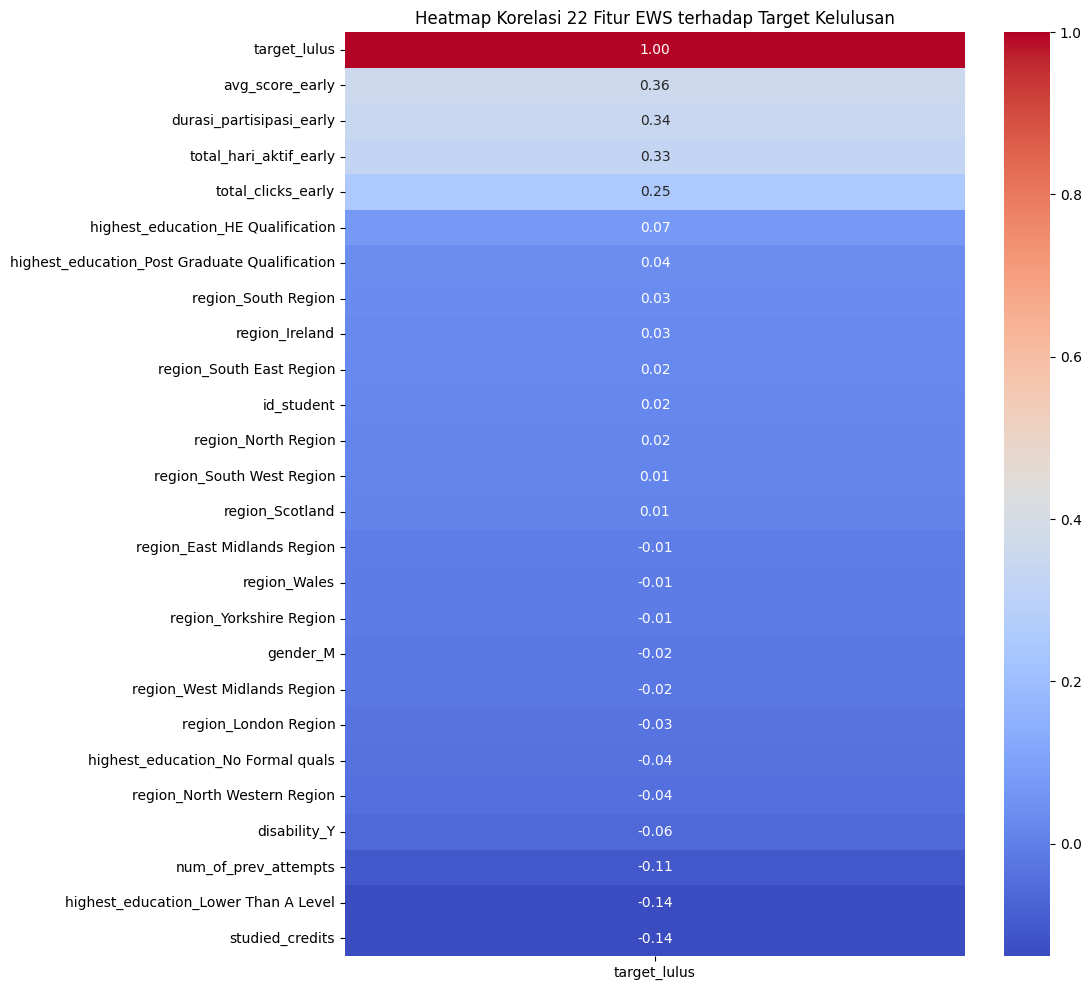


--- EDA: Box Plot Fitur Perilaku EWS 30 Hari vs Target ---


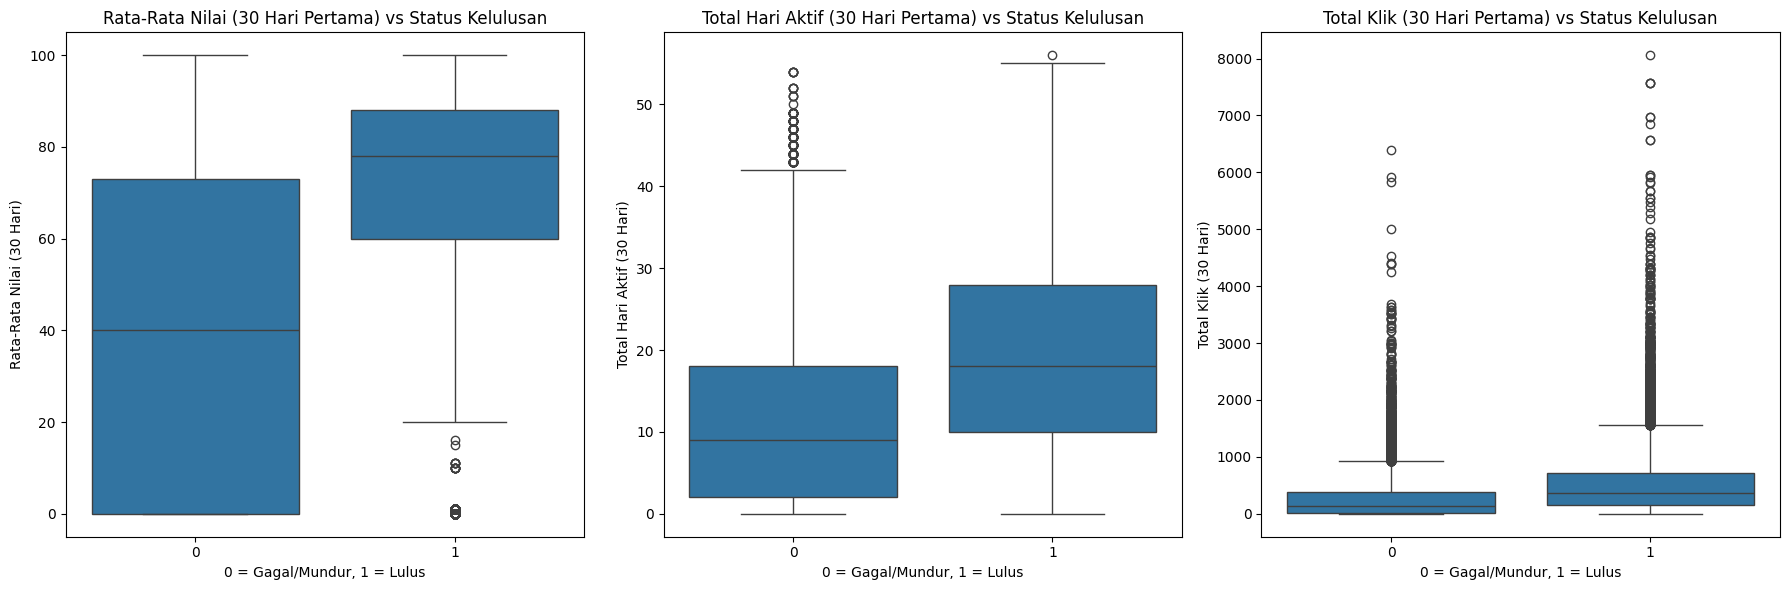

In [11]:
# ====================================================================
# LANGKAH E: EDA - Fokus Hubungan Fitur vs Target
# (Hapus K-Means Clustering)
# ====================================================================

# --- E.1: Heatmap Korelasi ---
print("\n--- EDA: Heatmap Korelasi Fitur EWS vs Target ---")
corr_matrix = df_expert.corr(numeric_only=True)
corr_target = corr_matrix[['target_lulus']].sort_values(by='target_lulus', ascending=False)

plt.figure(figsize=(10, 12))
sns.heatmap(
    corr_target, 
    annot=True,     
    cmap='coolwarm',
    fmt=".2f"       
)
plt.title('Heatmap Korelasi 22 Fitur EWS terhadap Target Kelulusan')
plt.show() # 

# --- E.2: Box Plot Perilaku EWS ---
print("\n--- EDA: Box Plot Fitur Perilaku EWS 30 Hari vs Target ---")
plt.figure(figsize=(18, 6))

# Visual 1: avg_score_early
plt.subplot(1, 3, 1) 
sns.boxplot(x='target_lulus', y='avg_score_early', data=df_expert)
plt.title('Rata-Rata Nilai (30 Hari Pertama) vs Status Kelulusan')
plt.xlabel('0 = Gagal/Mundur, 1 = Lulus')
plt.ylabel('Rata-Rata Nilai (30 Hari)')

# Visual 2: total_hari_aktif_early
plt.subplot(1, 3, 2)
sns.boxplot(x='target_lulus', y='total_hari_aktif_early', data=df_expert)
plt.title('Total Hari Aktif (30 Hari Pertama) vs Status Kelulusan')
plt.xlabel('0 = Gagal/Mundur, 1 = Lulus')
plt.ylabel('Total Hari Aktif (30 Hari)')

# Visual 3: total_clicks_early
plt.subplot(1, 3, 3) 
sns.boxplot(x='target_lulus', y='total_clicks_early', data=df_expert)
plt.title('Total Klik (30 Hari Pertama) vs Status Kelulusan')
plt.xlabel('0 = Gagal/Mundur, 1 = Lulus')
plt.ylabel('Total Klik (30 Hari)')

plt.tight_layout() 
plt.show() #

In [12]:
# ====================================================================
# LANGKAH F: UJI & TUNING MODEL KLASIFIKASI
# ====================================================================

# --- F.1: Definisikan Grup Fitur ---
# Grup 1: Fitur Baseline EWS (Hanya 3 fitur perilaku 30 hari)
fitur_baseline = ['total_clicks_early', 'total_hari_aktif_early', 'avg_score_early']
# Grup 2: Fitur Expert EWS (22 fitur gabungan 30 hari + demografis)
kolom_non_fitur = ['code_module', 'code_presentation', 'id_student', 'gender', 
                   'region', 'highest_education', 'imd_band', 'age_band', 
                   'num_of_prev_attempts', 'studied_credits', 'disability', 
                   'final_result', 'target_lulus']                  
fitur_expert = [col for col in df_expert.columns if col not in kolom_non_fitur]
y = df_expert['target_lulus']

print(f"\nFitur Baseline EWS: {len(fitur_baseline)} fitur")
print(f"Fitur Expert EWS: {len(fitur_expert)} fitur")


# --- F.2: Uji Model Baseline (RF 3 Fitur) ---
print("\n--- F.2: Uji Model Baseline (RF 3 Fitur) ---")
X_base = df_expert[fitur_baseline]
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_base, y, test_size=0.2, random_state=42
)
model_rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_base.fit(X_train_b, y_train_b)
y_pred_rf_base = model_rf_base.predict(X_test_b)
acc_rf_base_early = accuracy_score(y_test_b, y_pred_rf_base)
print(f"Akurasi RF Baseline: {acc_rf_base_early * 100:.2f}%")


# --- F.3: Uji Model RF Expert (22 Fitur) ---
print("\n--- F.3: Uji Model RF Expert (22 Fitur) ---")
X_exp_rf = df_expert[fitur_expert]
X_train_rf_e, X_test_rf_e, y_train_rf_e, y_test_rf_e = train_test_split(
    X_exp_rf, y, test_size=0.2, random_state=42
)
model_rf_expert = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_expert.fit(X_train_rf_e, y_train_rf_e)
y_pred_rf_expert = model_rf_expert.predict(X_test_rf_e)
acc_rf_expert_early = accuracy_score(y_test_rf_e, y_pred_rf_expert)
print(f"Akurasi RF Expert: {acc_rf_expert_early * 100:.2f}%")


# --- F.4: Uji Model XGBoost Expert (22 Fitur) + Tuning ---
print("\n--- F.4: Uji Model XGBoost Expert + Tuning ---")
X_exp = df_expert[fitur_expert]
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(
    X_exp, y, test_size=0.2, random_state=42
)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5]
}
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=0 
)
grid_search_xgb.fit(X_train_e, y_train_e)
model_xgb_expert = grid_search_xgb.best_estimator_
print(f"✅ Selesai Tuning! Parameter Terbaik: {grid_search_xgb.best_params_}")
print(f"Model XGBoost Expert (Final) siap.")


Fitur Baseline EWS: 3 fitur
Fitur Expert EWS: 22 fitur

--- F.2: Uji Model Baseline (RF 3 Fitur) ---
Akurasi RF Baseline: 66.31%

--- F.3: Uji Model RF Expert (22 Fitur) ---
Akurasi RF Expert: 70.23%

--- F.4: Uji Model XGBoost Expert + Tuning ---
✅ Selesai Tuning! Parameter Terbaik: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Model XGBoost Expert (Final) siap.



--- HASIL FINAL: PERBANDINGAN MODEL EWS (Prediksi 30 Hari) ---
Akurasi Model Baseline (RF 3 Fitur): 66.31%
Akurasi Model RF Expert (RF 22 Fitur): 70.23%
Akurasi Model XGBoost Expert (XGB 22 Fitur): 71.04%

--- Classification Report (Model Final - XGBoost 22 Fitur) ---
              precision    recall  f1-score   support

   Gagal (0)       0.74      0.70      0.72      3468
   Lulus (1)       0.68      0.72      0.70      3051

    accuracy                           0.71      6519
   macro avg       0.71      0.71      0.71      6519
weighted avg       0.71      0.71      0.71      6519


--- G.2: Confusion Matrix ---


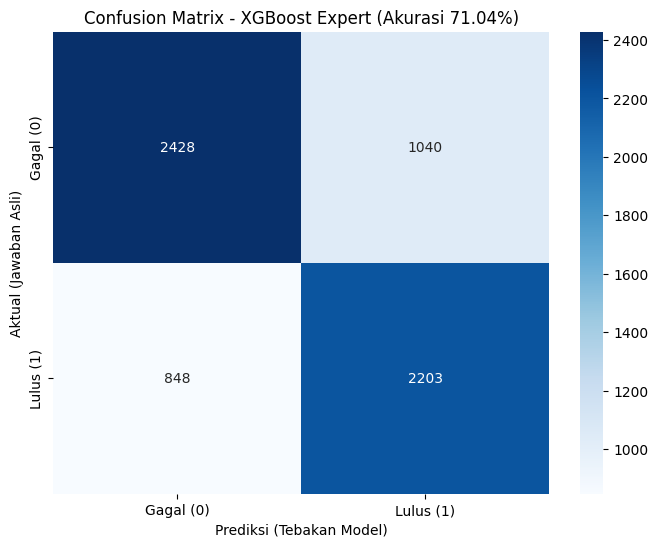


--- G.3: Kurva ROC AUC ---
ROC AUC Score Model EXPERT: 0.7111


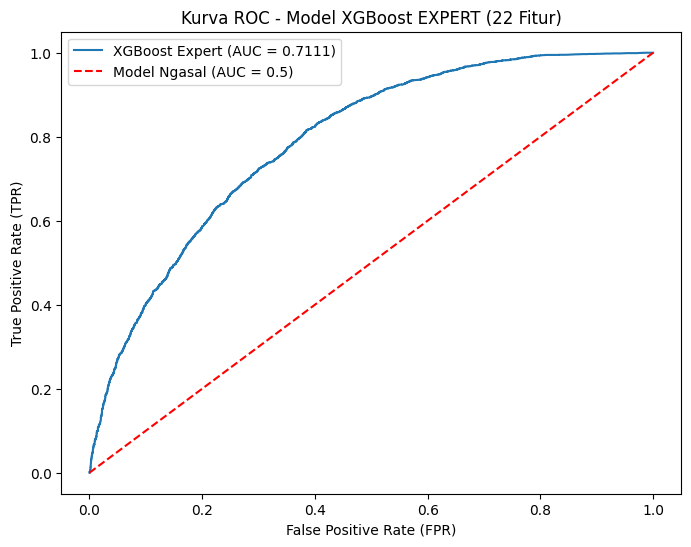

In [13]:
# ====================================================================
# LANGKAH G: EVALUASI PERBANDINGAN DAN METRIK FINAL
# ====================================================================

y_pred_expert = model_xgb_expert.predict(X_test_e)
acc_xgb_expert_early = accuracy_score(y_test_e, y_pred_expert)

print("\n--- HASIL FINAL: PERBANDINGAN MODEL EWS (Prediksi 30 Hari) ---")
print(f"Akurasi Model Baseline (RF 3 Fitur): {acc_rf_base_early * 100:.2f}%")
print(f"Akurasi Model RF Expert (RF 22 Fitur): {acc_rf_expert_early * 100:.2f}%")
print(f"Akurasi Model XGBoost Expert (XGB 22 Fitur): {acc_xgb_expert_early * 100:.2f}%")

print("\n--- Classification Report (Model Final - XGBoost 22 Fitur) ---")
print(classification_report(y_test_e, y_pred_expert, target_names=['Gagal (0)', 'Lulus (1)']))


# --- G.2: Confusion Matrix ---
print("\n--- G.2: Confusion Matrix ---")
cm_expert = confusion_matrix(y_test_e, y_pred_expert)

plt.figure(figsize=(8, 6)) 
sns.heatmap(
    cm_expert, 
    annot=True,     
    fmt='d',        
    cmap='Blues',   
    xticklabels=['Gagal (0)', 'Lulus (1)'], 
    yticklabels=['Gagal (0)', 'Lulus (1)']  
)
plt.title(f'Confusion Matrix - XGBoost Expert (Akurasi {acc_xgb_expert_early*100:.2f}%)')
plt.ylabel('Aktual (Jawaban Asli)')
plt.xlabel('Prediksi (Tebakan Model)')
plt.show() # 


# --- G.3: Kurva ROC AUC ---
print("\n--- G.3: Kurva ROC AUC ---")
roc_auc = roc_auc_score(y_test_e, y_pred_expert)
y_probs = model_xgb_expert.predict_proba(X_test_e)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_e, y_probs)

print(f"ROC AUC Score Model EXPERT: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost Expert (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', label='Model Ngasal (AUC = 0.5)')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Kurva ROC - Model XGBoost EXPERT (22 Fitur)')
plt.legend()
plt.show() #


--- H.1: Feature Importance ---

10 Fitur Paling Penting (dari 22 fitur):
avg_score_early                         0.253311
durasi_partisipasi_early                0.119656
total_hari_aktif_early                  0.118341
highest_education_Lower Than A Level    0.098352
gender_M                                0.090260
disability_Y                            0.048821
total_clicks_early                      0.043769
region_South Region                     0.026874
highest_education_No Formal quals       0.025994
region_South West Region                0.020469
dtype: float32


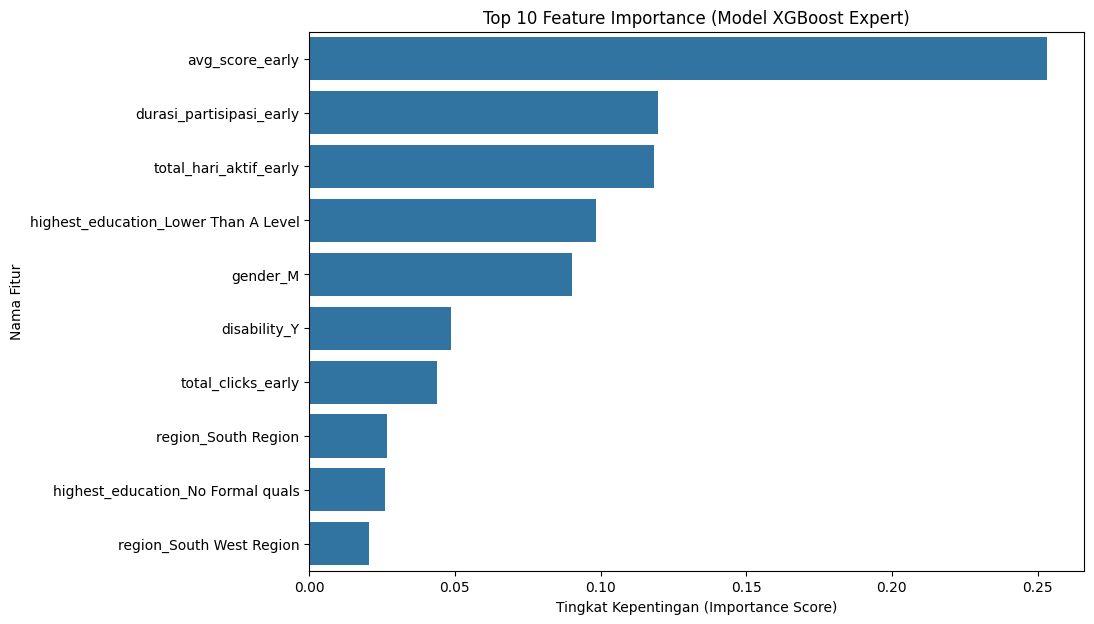

100%|██████████| 100/100 [00:04<00:00, 22.10it/s]



--- H.2: SHAP Summary Plot (Global Importance) ---


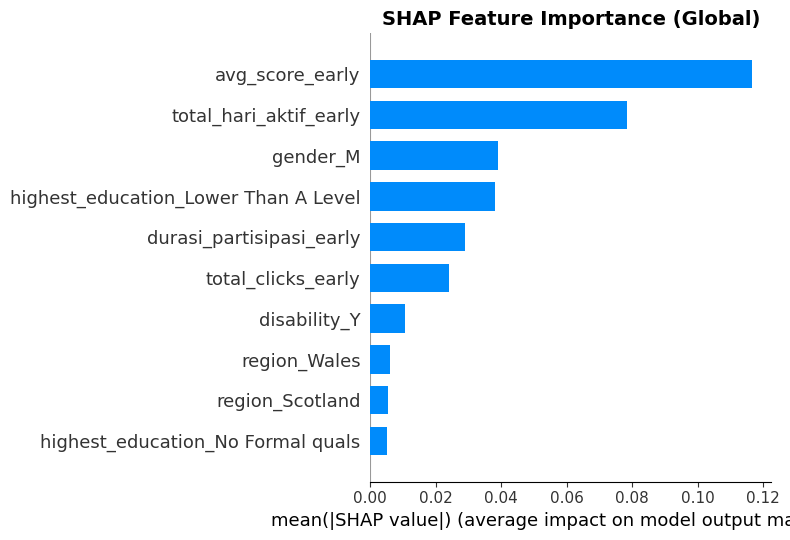


--- H.2: SHAP Summary Plot (Distribusi Beeswarm) ---


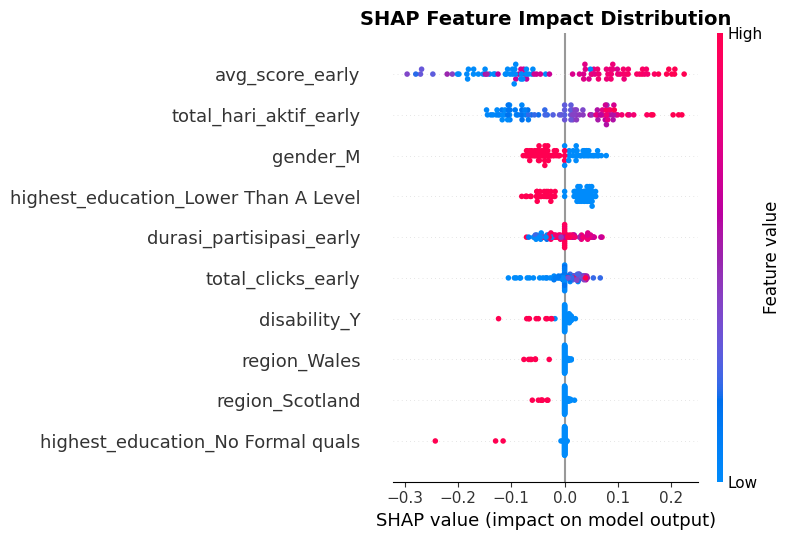


✅ Analisis Klasifikasi EWS Selesai.


In [14]:
# ====================================================================
# LANGKAH H: INTERPRETASI MODEL FINAL (SHAP)
# ====================================================================

# --- H.1: Feature Importance (Bawaan XGBoost) ---
print("\n--- H.1: Feature Importance ---")
importances = model_xgb_expert.feature_importances_
feature_names = fitur_expert
feat_imp_series = pd.Series(importances, index=feature_names)
top_10_features = feat_imp_series.sort_values(ascending=False).head(10)

print(f"\n10 Fitur Paling Penting (dari {len(fitur_expert)} fitur):\n{top_10_features}")

plt.figure(figsize=(10, 7)) 
sns.barplot(
    x=top_10_features.values, 
    y=top_10_features.index, 
    orient='h'
) 
plt.title('Top 10 Feature Importance (Model XGBoost Expert)')
plt.xlabel('Tingkat Kepentingan (Importance Score)')
plt.ylabel('Nama Fitur')
plt.show() # 


# --- H.2: SHAP Analysis ---

# Buat fungsi predict wrapper
def model_predict(X):
    if hasattr(X, 'values'):
        X = X.values
    return model_xgb_expert.predict_proba(X)[:, 1]

# Ambil background data (sample dari training set)
n_background = min(100, len(X_train_e))
background = shap.sample(X_train_e, n_background, random_state=42)

# Buat KernelExplainer
explainer = shap.KernelExplainer(model_predict, background)

# Hitung SHAP values untuk subset test data
n_explain = min(100, len(X_test_e))
test_sample = X_test_e.sample(n_explain, random_state=42)
shap_values = explainer.shap_values(test_sample, nsamples=100)

print("\n--- H.2: SHAP Summary Plot (Global Importance) ---")
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values, 
    test_sample, 
    plot_type="bar", 
    max_display=10,
    show=False
)
plt.title("SHAP Feature Importance (Global)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() # 

print("\n--- H.2: SHAP Summary Plot (Distribusi Beeswarm) ---")
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values, 
    test_sample, 
    max_display=10,
    show=False
)
plt.title("SHAP Feature Impact Distribution", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() # 

print("\n✅ Analisis Klasifikasi EWS Selesai.")

In [17]:
# --- LANGKAH J: ANALISIS HASIL PREDIKSI SPESIFIK ---

# 1. Ambil kolom identitas dan aktual dari df_expert menggunakan indeks data uji.
# df_expert adalah tabel master yang masih menyimpan id_student dan target/final_result.
df_results = df_expert.loc[X_test_e.index, 
                           ['id_student', 'final_result', 'target_lulus', 'avg_score_early']].copy()

# 2. Tambahkan hasil prediksi (y_pred_expert) dan probabilitas.
df_results['Prediksi_Lulus'] = y_pred_expert
df_results['Probabilitas_Lulus'] = model_xgb_expert.predict_proba(X_test_e[fitur_expert])[:, 1]

# 3. Memberi label prediksi yang lebih mudah dibaca
df_results['Hasil_Prediksi'] = df_results['Prediksi_Lulus'].apply(
    lambda x: 'LULUS (1)' if x == 1 else 'GAGAL/MUNDUR (0)'
)
df_results['Hasil_Aktual'] = df_results['target_lulus'].apply(
    lambda x: 'LULUS (1)' if x == 1 else 'GAGAL/MUNDUR (0)'
)


# --- MENAMPILKAN DATA ---
print("=============================================================")
print("✅ HASIL PREDIKSI MAHASISWA PADA DATA UJI")
print("=============================================================")

# A. Mahasiswa yang Diprediksi LULUS (dan Paling Akurat/Yakin Lulus)
print("\n--- A. 10 Mahasiswa yang DIPREDIKSI LULUS (Probabilitas Tertinggi) ---")
df_predicted_pass = df_results[df_results['Prediksi_Lulus'] == 1].sort_values(
    by='Probabilitas_Lulus', ascending=False
).head(10)
print(df_predicted_pass[['id_student', 'final_result', 'Hasil_Aktual', 'Probabilitas_Lulus']])


# B. Mahasiswa yang Diprediksi GAGAL/MUNDUR (dan Paling Yakin Gagal)
print("\n--- B. 10 Mahasiswa yang DIPREDIKSI GAGAL/MUNDUR (Probabilitas Terendah) ---")
df_predicted_fail = df_results[df_results['Prediksi_Lulus'] == 0].sort_values(
    by='Probabilitas_Lulus', ascending=True
).head(10)
print(df_predicted_fail[['id_student', 'final_result', 'Hasil_Aktual', 'Probabilitas_Lulus', 'avg_score_early']])

# C. Kasus False Negative (Mahasiswa AKTUAL LULUS, tapi diprediksi GAGAL)
print("\n--- C. Kasus False Negative (MAHASISWA BERESIKO TINGGI: Aktual Lulus, Prediksi Gagal) ---")
df_false_negative = df_results[(df_results['target_lulus'] == 1) & (df_results['Prediksi_Lulus'] == 0)]
print(f"Total False Negative: {len(df_false_negative)} kasus.")
print("Contoh 5 Kasus False Negative (diperlukan intervensi):")
print(df_false_negative[['id_student', 'final_result', 'Probabilitas_Lulus', 'avg_score_early']].head(5))

# D. Kasus False Positive (Mahasiswa AKTUAL GAGAL, tapi diprediksi LULUS)
print("\n--- D. Kasus False Positive (KEPERCAYAAN SEMU: Aktual Gagal, Prediksi Lulus) ---")
df_false_positive = df_results[(df_results['target_lulus'] == 0) & (df_results['Prediksi_Lulus'] == 1)]
print(f"Total False Positive: {len(df_false_positive)} kasus.")
print("Contoh 5 Kasus False Positive:")
print(df_false_positive[['id_student', 'final_result', 'Probabilitas_Lulus', 'avg_score_early']].head(5))

# E. Ouput File Akhir
# Menentukan nama file output
output_filename = 'hasil_prediksi_mahasiswa_ews_final.csv'

# Mengekspor DataFrame df_results ke file CSV
# index=False memastikan kolom indeks (yang berisi ID baris internal Pandas) tidak ikut terekspor
df_results.to_csv(output_filename, index=False)

print("=============================================================")
print(f"✅ Data hasil prediksi berhasil diekspor ke: {output_filename}")
print("=============================================================")

✅ HASIL PREDIKSI MAHASISWA PADA DATA UJI

--- A. 10 Mahasiswa yang DIPREDIKSI LULUS (Probabilitas Tertinggi) ---
       id_student final_result      Hasil_Aktual  Probabilitas_Lulus
11915      622374         Pass         LULUS (1)            0.959394
9020       420935  Distinction         LULUS (1)            0.954417
24177      335644         Fail  GAGAL/MUNDUR (0)            0.948968
13549      476964  Distinction         LULUS (1)            0.946803
25487      595106  Distinction         LULUS (1)            0.945735
25246      586781  Distinction         LULUS (1)            0.944996
22222     1674799  Distinction         LULUS (1)            0.944691
23700      560431  Distinction         LULUS (1)            0.942756
24239      380435  Distinction         LULUS (1)            0.942334
27520      634479         Fail  GAGAL/MUNDUR (0)            0.940661

--- B. 10 Mahasiswa yang DIPREDIKSI GAGAL/MUNDUR (Probabilitas Terendah) ---
       id_student final_result      Hasil_Aktual  